# DAML Project - Net Attack

Michal Grochmal <michal.grochmal@city.ac.uk>

We got webserver logs.
Each line in the logs is an HTTP request to a honeypot webserver.
We also have labels that tell us whether a specific line was
a malicious request or not.
With this we should try to build an algorithm that,
given a new requests, classifies it as malicious or not malicious.

The idea of our project is to experience data munging,
i.e. transformig data into a useful form for ML
and then performing a prototype ML algorithm.
It is completely fine to use different tools to preprocess the data
and only load it for the `sklearn` bit.
Yet, we are going to use `pandas` to perform the preprocessing,
since that is what we learned.

For a start we will just do the common imports.
Plus `json` since the data is JSON formatted.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

In the data file the JSON strings are in a binary format.
Or, more exactly, the JSON string values are either in plain binary
dumps or are encoded in the `latin-1` character set.
The labels (in the labels file) are simply a number per line,
0 meaning a normal sample and 1 meaning an anomaly.

Note that every line in the file is a complete JSON structure,
i.e. the entire file is not valid JSON, every line is.
We need to go through the file line by line and parse the JSON on each line.
When we load everything into `pandas` we should also have a look at some records.

In [2]:
with open('../data/net-attack-access.log', encoding='latin-1') as f:
    df = pd.DataFrame(json.loads(l) for l in f)
with open('../data/net-attack-access.labels', encoding='latin-1') as f:
    df['label'] = pd.Series(int(l) for l in f)
df.head()

,bytes_sent,content_length,content_type,cookie_csrftoken,cookie_sessionid,cookie_userid,geoip_city,geoip_country_code3,geoip_country_name,geoip_latitude,...,ssl_cipher,ssl_curves,ssl_protocol,ssl_session_reused,status,time_iso8601,upstream_cache_status,upstream_response_time,upstream_status,label
0,486,,,,,,,USA,United States,13.7500,...,ECDHE-RSA-AES128-GCM-SHA256,0x001d:prime256v1:secp384r1,TLSv1.2,.,301,2018-05-11T03:33:26+00:00,,,,0
1,2999,,,,,,Saint Petersburg,RUS,Russian Federation,59.8944,...,,,,,200,2018-05-11T03:34:33+00:00,MISS,0.000,200,0
2,481,,,,,,,USA,United States,13.7500,...,ECDHE-RSA-AES128-GCM-SHA256,0x001d:prime256v1:secp384r1,TLSv1.2,.,301,2018-05-11T03:51:23+00:00,,,,0
3,449,,,,,,Edison,USA,United States,40.4981,...,,,,,301,2018-05-11T04:02:52+00:00,,,,0
4,792,,,,,,Saint Petersburg,RUS,Russian Federation,59.8944,...,,,,,200,2018-05-11T05:09:04+00:00,,,,0


That looks alright,
we got the encoding right and all strings are Python strings now.
This also means that the majority of the data types in the data frame are strings.
Most machine learning techniques will perform badly (or not at all) on strings,
we need a way of transforming them into numbers.

But before that let's check the actual data types.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 39 columns):
bytes_sent                10789 non-null int64
content_length            10789 non-null object
content_type              10789 non-null object
cookie_csrftoken          10789 non-null object
cookie_sessionid          10789 non-null object
cookie_userid             10789 non-null object
geoip_city                10789 non-null object
geoip_country_code3       10789 non-null object
geoip_country_name        10789 non-null object
geoip_latitude            10789 non-null object
geoip_longitude           10789 non-null object
geoip_region_name         10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null object
http2                     10789 non-null object
http_referer              10789 non-null object
http_user_agent           10789 non-null object
http_x_csrf_token         10789 non-null object
http_x_forwarded_for      10

We do already have some numbers and probably can keep most of these.
Yet, before that, judging from the names - and some domain knowledge on webservers - we can
say that there is likely a good deal of repetition and missing data.

In other words, we need to find ourselves which columns of the data frame
will be useful for us and which will not be useful.
One way to do it is to check the number of unique value in each column.
If the number of unique values provides with enough variance to
discern things we keep the column, otherwise we drop it.

In [4]:
for i in df.columns:
    print(i, len(df[i].unique()))

bytes_sent 379
content_length 21
content_type 16
cookie_csrftoken 1
cookie_sessionid 1
cookie_userid 2
geoip_city 609
geoip_country_code3 84
geoip_country_name 84
geoip_latitude 772
geoip_longitude 777
geoip_region_name 373
gzip_ratio 37
host 42
http2 2
http_referer 141
http_user_agent 282
http_x_csrf_token 1
http_x_forwarded_for 7
remote_addr 2444
remote_port 6806
request 472
request_id 10789
request_length 479
request_method 6
request_time 67
request_uri 384
scheme 2
server_protocol 4
ssl_cipher 8
ssl_curves 22
ssl_protocol 4
ssl_session_reused 3
status 12
time_iso8601 7630
upstream_cache_status 4
upstream_response_time 31
upstream_status 6
label 2


OK, several columns do not have enough variance to tell us anything
(for example `http_x_csrf_token` is always empty).
Other columns have too much variance, i.e. comparable to the size of the dataset
(for example `remote_addr` has as many unique values as a quarter of the dataset).

Finally, we can use domain knowledge to reason about a handful of columns.
For example, `request_id` seem to be some unique ID generated per connection,
certainly not useful for us.
Also, `remote_port` has lots of variance; and if it it the remote port
from which someone connected to the webserver we can argue that it is a random value
(ephemeral ports used to connect to a webserver from a browser or script
are indeed assigned randomly).

In [5]:
df = df.drop([
    'content_length',         # only present in POST, duplicate of request_method: POST
    'cookie_csrftoken',       # no variance
    'cookie_sessionid',       # no variance
    'cookie_userid',          # low variance
    'geoip_city',             # use geoip_country_name
    'geoip_country_code3',    # use geoip_country_name
    'geoip_latitude',         # use geoip_country_name
    'geoip_latitude',         # use geoip_country_name
    'geoip_longitude',        # use geoip_country_name
    'geoip_region_name',      # use geoip_country_name
    'http_x_csrf_token',      # no variance
    'remote_addr',            # too much variance
    'remote_port',            # this is actually random
    'request_id',             # unique ID
    'ssl_curves',             # use ssl_cipher
    'ssl_protocol',           # use ssl_cipher,
    'upstream_cache_status',  # use upstream_response_time
    'upstream_status',        # use upstream_response_time
], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 22 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null object
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null object
http2                     10789 non-null object
http_referer              10789 non-null object
http_user_agent           10789 non-null object
http_x_forwarded_for      10789 non-null object
request                   10789 non-null object
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null object
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non-null object
status                    10

And we dropped all the columns that would not be useful.
This includes columns containing (almost) repeated information.

We can now go back to the problem that we still have strings, not numbers.
One way to transform strings to numbers is one-hot-encoding,
yet we still have several columns which have way too many values
to allow for one-hot-encoding.
Instead we will try a different way of transforming strings to numbers:
We will simply take the length of the string.

In [6]:
len_columns = [
    'content_type',
    'host',
    'http_referer',
    'http_user_agent',
    'http_x_forwarded_for',
    'request',
    'request_uri',
]
for c in len_columns:
    df[c] = df[c].str.len()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 22 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null int64
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null int64
http2                     10789 non-null object
http_referer              10789 non-null int64
http_user_agent           10789 non-null int64
http_x_forwarded_for      10789 non-null int64
request                   10789 non-null int64
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null int64
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non-null object
status                    10789 non

We left out 10 columns, these have better ways for us to encode into numbers.
Some of the columns *are* numbers,
yet `pandas` could not read them as numbers because some values are missing.

If we fill the missing values by hand,
in this case we will say that a missing value is a zero,
we can convert these columns to numbers directly.

In [7]:
numbers = [
    'gzip_ratio',
    'upstream_response_time',
]
for c in numbers:
    df.loc[df[c] == '', c] = 0  # prevent NaNs
    df[c] = pd.to_numeric(df[c])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 22 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null int64
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null float64
host                      10789 non-null int64
http2                     10789 non-null object
http_referer              10789 non-null int64
http_user_agent           10789 non-null int64
http_x_forwarded_for      10789 non-null int64
request                   10789 non-null int64
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null int64
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non-null object
status                    10789 no

Two columns we managed to convert directly to numbers.
That's good, 8 columns to go.

These columns do not have too many values in them.
In other words,
these are the columns for which one-hot-encoding makes sense.
Here we also transform the column *status*,
that column is already a number but an HTTP status does not convey a numeric value.
For example, HTTP 404 NOT FOUND is not *"better"* (or greater) than HTTP 200 OK.

In [8]:
dummies = [
    'geoip_country_name',
    'http2',
    'request_method',
    'scheme',
    'server_protocol',
    'ssl_cipher',
    'ssl_session_reused',
    'status',
]
df = pd.get_dummies(df, columns=dummies)
df.columns

Index(['bytes_sent', 'content_type', 'gzip_ratio', 'host', 'http_referer',
       'http_user_agent', 'http_x_forwarded_for', 'request', 'request_length',
       'request_time',
       ...
       'status_302', 'status_304', 'status_400', 'status_403', 'status_404',
       'status_408', 'status_418', 'status_429', 'status_500', 'status_502'],
      dtype='object', length=135)

This leaves us with one last column to convert: the time.

Let us think for a moment about this one.
We are trying to classify malicious requests from non-malicious ones,
it is reasonable to argue that malicious requests in some region
of the world are likely to happen at a certain time.
For example, *local* malicious traffic is most often seen late at night.
Therefore we are more interested in the time of day a request happened
rather than the exact date and time it happened.
We will take the time of day as the hour (in 24 hour format)
in which the request happened.

In [9]:
df['time_of_day'] = pd.to_datetime(df['time_iso8601']).dt.hour
df = df.drop(['time_iso8601'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Columns: 135 entries, bytes_sent to time_of_day
dtypes: float64(3), int64(11), uint8(121)
memory usage: 2.4 MB


And we are done with bashing the data into a form that we can use.
In other words, we have a dataset on which we can operate ML algorithms.

The first thing we should do is to put aside part of the dataset as a test set.
We then need to make sure that our models do not see this test set
during training and cross validation.
The test set will be our way of validating cross validated algorithms.
We set 20% of our data as the test set.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('label', axis=1).values, df['label'].values, test_size=0.2)

The first algorithm we should try should be a simple one.
An algorithm which will give us a *baseline* so that we know
how badly things may go.

We will choose Naive Bayes as our baseline,
we saw before that this is a good baseline algorithm.

In [11]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.3540315106580167

OK, so that is akin of (or even worse than) a random choice.
But wait, this data is not 50% anomalies, 50% normal.

Let's check the distribution of the data:

In [12]:
np.sum(df['label'] == 1) / df.shape[0]

0.08870145518583743

So we have about 9% anomalies.
This means that a trivial algorithm,
one that would say that every data point is normal,
would still get around 90% of the labels right.
Given that we are scoring with slightly better
scoring functions than plain accuracy (mean accuracy, F1 score),
we can argue that a trivial algorithm would get a score of around 80%.

Our attempt above is doing much worse than a trivial algorithm.
In other words we are clearly doing something very wrong.
What we did wrong is that we forgot to scale the data.
Note that using either `StandardScaler` or `MinMaxScaler` works.
For the baseline, we will just use one scaler, later we should try both.

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(MinMaxScaler(), MultinomialNB())
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9494902687673772

That looks like a good score.
Moreover since this is just a baseline.

But wait, we just checked that we do not have a balanced dataset.
In other words, there's a good chance that this algorithm just classifies
almost everything as non-anomalies and gets a good score just because
most things in the dataset are not anomalies.

We need to break down our evaluation class by class.
One way to do it is with a confusion matrix.

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test))

array([[1959,   10],
       [  99,   90]])

Ops, that ain't good.
There are more *False Negatives* (anomalies classified as non-anomalies)
than *True Negatives*!

Yet, we did learn one thing:
we need to check the confusion matrix to evaluate our algorithms.
And we also do have a baseline,
any algorithms performing worse than this we can straight away eliminate.

Onto more complicated algorithms.
Let's start with an SVM.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = make_pipeline(MinMaxScaler(), SVC(gamma='scale'))
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10]},
]
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)
confusion_matrix(y_test, grid.predict(X_test))

array([[1966,    3],
       [  17,  172]])

Much, much better.
We can see that we managed to classify the majority of both classes correctly.
This is a good algorithm, and we could use it as the algorithm to pass
new data through and detect anomalies.
Yet, we should still try to tweak it, and see if there are differences.

We have not yet tried the `StandardScaler`,
which is more resistant to outliers than `MinMaxScaler`.
If the outliers affect the workings of our SVM,
we should be able to find so by comparing the same model trained under
different scalers.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), SVC(gamma='scale'))
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10]},
]
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)
confusion_matrix(y_test, grid.predict(X_test))

array([[1967,    2],
       [  12,  177]])

There isn't a big difference.
This is still a good algorithm but it is hard to say if
it is better or worse than the previous attempt.
Both classes are reasonably classified in both attempts.

Instead let's try another family of algorithms.
Let's try a Random Forest, for a start with a small number of trees.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([('scaler', StandardScaler()),
                  ('rfc', RandomForestClassifier(n_estimators=10))])
param_grid = {
    'rfc__min_samples_split': [3, 10, 20],
    'rfc__min_samples_leaf': [2, 3, 6],
    'rfc__bootstrap': [True, False],
}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)
confusion_matrix(y_test, grid.predict(X_test))

array([[1969,    0],
       [   9,  180]])

The RFC performs at pretty much the same level as our previous attempts with SVMs
(perhaps a little better but this is more dependent on the data split
rather than the algorithm itself).
This probably means that we reached the amount of knowledge that we can
get out of the data we have.
In other words, this is likely as good as it gets for this amount of data.

Just as an illustration, let's draw this confusion matrix.
i.e. with the true and predicted labels on the axes.

array([[1969,    0],
       [   9,  180]])

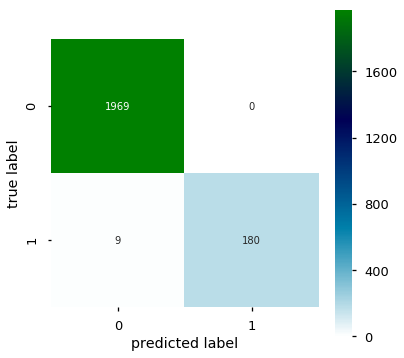

In [18]:
import seaborn as sns

m = confusion_matrix(y_test, grid.predict(X_test))
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(m, square=True, annot=True, fmt='d', cmap='ocean_r',
            xticklabels=[0, 1], yticklabels=[0,1], ax=ax)
ax.set(xlabel='predicted label', ylabel='true label')
m

This algorithms is good enough for a production environment.
One more thing that would be good to add to it is some control over
*False Negatives* and *False Positives*,
i.e. give the algorithm a control over sensitivity to anomalies.
A higher sensitivity would mean more normal traffic classified as an
anomaly (FP), and lower sensitivity more anomalies undetected (FN).

Both the SVC and the RFC classifiers support a `class_weight` parameter.
Adding more weight to the anomaly class (1) increases sensitivity,
and reducing that weight decreases sensitivity.
The default is the same weight for all classes,
which for our case is a minimum sensitivity with almost no False Positives.

Finally, such tweaks to `class_weight` depend of our requirements for
the algorithm.  The defaults are a good start for a production environment
on a webserver: most anomalies are caught but the admin is almost never
bothered by False Positives.

## Extras

The outlier detection field also has very specialized algorithms for the
task of anomaly detection.
They may or may not perform better than what we have used.
As an extra exercise you can use a handful of the specialized algorithms,
e.g. Local Outlier Factor (for a baseline) and then Isolation Forest.

[sklearn Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html)

The main difference between what we did above and the specialized algorithms,
is that the labels are encoded in a different form.
Typically, in outlier detection the normal samples are encoded as 1 and anomalies as -1.
This should be easy to adapt with two lines of `NumPy` code.